## Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sarawater as sara

plt.style.use("stylesheet.mplstyle")

## I/O paths and directories creation

In [2]:
input_csv_filepath = os.path.join('data', 'daily_discharge_7y.csv')
min_release_filepath = os.path.join('data', 'minimum_flow_requirements.csv')

## Read the discharge data and create a reach object

### Read the CSV data

In [3]:
# Read CSV with automatic date parsing
reach_df = pd.read_csv(input_csv_filepath, parse_dates=['Date'])

# Convert to list of datetime objects
datetime_list = reach_df['Date'].dt.to_pydatetime().tolist()

# Put the discharge data into a numpy array
discharge_data = np.array(reach_df["Q"].to_list())

C:\Users\gbarile\AppData\Local\Temp\ipykernel_16656\864773801.py:5: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  datetime_list = reach_df['Date'].dt.to_pydatetime().tolist()


### Initialize a reach object

In [4]:
Qabs_max = 3
my_reach = sara.Reach("My Reach", datetime_list, discharge_data, Qabs_max)

## Add scenarios to the reach object

#### Minimum Flow Requirement (MFR) scenario

In [5]:
# Read the minimum release values from CSV
minrel_df = pd.read_csv(min_release_filepath, header=None)

# Get the minimum release values (second column), convert l/s to m3/s
Qreq_months = np.array(minrel_df[1].tolist()) / 1000.0

# Create a constant scenario with these values
MFR_scenario = sara.ConstScenario(
    name="MFR",
    description="Minimum Flow Requirement scenario from CSV file",
    reach=my_reach,
    Qreq_months=Qreq_months
)

# Add the scenario to the reach
my_reach.add_scenario(MFR_scenario)

#### Ecological scenario (using the built-in method)

In [6]:
my_reach.add_ecological_flow_scenario("DE", "Ecological Flow Scenario with default parameters")

Scenario(name=DE, description=Ecological Flow Scenario with default parameters, reach=My Reach)

#### Proportional release scenario (using the built-in method)

In [7]:
prop_scenario = sara.PropScenario(
    name="06_30",
    description="Proportional scenario",
    reach=my_reach,
    Qbase=0.6*np.min(Qreq_months),
    c_Qin=0.3,
    Qreq_min=np.min(Qreq_months),
    Qreq_max=np.max(my_reach.scenarios[1].Qreq_months),
)
my_reach.add_scenario(prop_scenario)

#### Let's check we added the scenarios correctly

In [8]:
my_reach.print_scenarios()

scenarios[0]: MFR | Minimum Flow Requirement scenario from CSV file
scenarios[1]: DE | Ecological Flow Scenario with default parameters
scenarios[2]: 06_30 | Proportional scenario


## Compute the released flow discharge for each scenario and compute the IHA indices (IARI and normalized IHA)

In [9]:
for scenario in my_reach.scenarios:
    scenario.compute_Qrel()
    scenario.compute_IHA_index(index_metric="IARI")
    scenario.compute_IHA_index(index_metric="normalized_IHA")
    scenario.compute_natural_abstracted_volumes()

## Analyse the results using a ReachPlotter object

### Initialize the plotter

In [10]:
plotter = sara.ReachPlotter(my_reach)

### Plot samples of released flow discharge

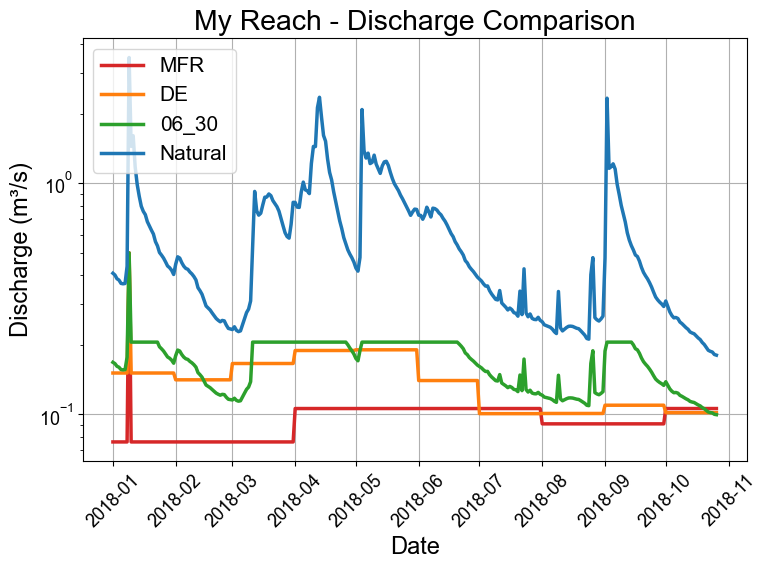

In [11]:
year = 2018
start_date = f"{year}-01-01"
end_date = f"{year}-12-31"
plotter.plot_scenarios_discharge(start_date=start_date, end_date=end_date)
plt.xticks(rotation=45)
plt.tight_layout()

### IHA and IARI plots

<Axes: title={'center': 'My Reach - IARI vs Abstracted Volume'}, xlabel='Ecohydrological quality $(1 - IARI)$ [-]', ylabel='Normalized abstracted volume $V_{der}/V_{nat}$ [-]'>

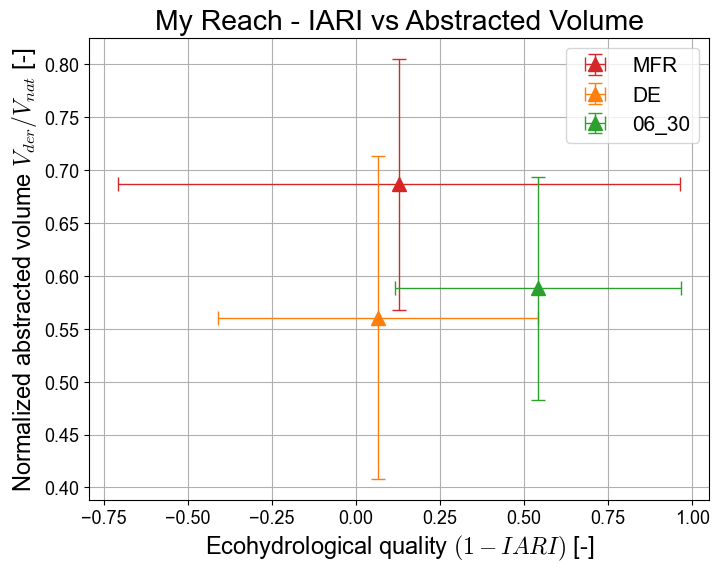

In [12]:
#plotter.plot_iha_parameters()
#plotter.plot_iha_boxplots()
#plotter.plot_iari_groups()
#plotter.plot_iari_summary()
#plotter.plot_cases_duration()
#plotter.plot_monthly_abstraction()
#plotter.plot_nIHA_summary()
#plotter.plot_nIHA_vs_volume()
plotter.plot_iari_vs_volume(save=True)